In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from pyfishsensedev.segmentation.fish import FishSegmentationFishialPyTorch, FishSegmentationFishialOnnx
from pyfishsensedev.points_of_interest.fish import FishPointsOfInterestDetector
from pyfishsensedev.image import ImageRectifier, RawProcessor, ColorCorrection
from pyfishsensedev.depth_map import LaserDepthMap, DepthAnythingDepthMap
from pyfishsensedev.laser.nn_laser_detector import NNLaserDetector
from pyfishsensedev.calibration import LensCalibration, LaserCalibration
from pyfishsensedev.image.image_processors.raw_processor_old import RawProcessorOld

import pyfishsense
FishSegmentation = pyfishsense.fish.FishSegmentation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# plt.rcParams['figure.figsize'] = [25, 12.5]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
lens_calibration_path = Path("./data/lens-calibration.pkg")
laser_calibration_path = Path("./data/laser-calibration.pkg")

# input_file = "./data/P7170081.ORF"
input_file = "./data/P8030201.ORF"
# input_file = "./data/P8030161.ORF"
# input_file = "./data/P8030158.ORF"
# input_file = "./data/P8030088.ORF"
# input_file = "./data/P8030135.ORF"

In [22]:
lens_calibration = LensCalibration()
lens_calibration.load(lens_calibration_path)

laser_calibration = LaserCalibration()
laser_calibration.load(laser_calibration_path)

In [23]:
def uint8_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 255

def uint16_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 65535

def double_2_uint8(img: np.ndarray) -> np.ndarray:
    return (img * 255).astype(np.uint8)

def uint16_2_uint8(img: np.ndarray) -> np.ndarray:
    return double_2_uint8(uint16_2_double(img))

def imshow(img: np.ndarray | Image.Image):
    if hasattr(img, "dtype"):
        arr = img
    elif isinstance(img, Image.Image):
        arr = np.array(img)

    if arr.dtype == np.uint16:
        arr = uint16_2_uint8(img)
    elif arr.dtype == float:
        arr = double_2_uint8(arr / arr.max())

    plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))

In order to have greater control over the image processing steps, begin with the RAW output.  This allows us to keep more information than would be possible otherwise.

In [24]:

raw_processor = RawProcessor(Path(input_file))
dark_raw_processor = RawProcessorOld(Path(input_file), enable_histogram_equalization=False)

image_rectifier = ImageRectifier(lens_calibration)

img = next(raw_processor.__iter__())
img = image_rectifier.rectify(img)

img_dark = next(dark_raw_processor.__iter__())
img_dark = image_rectifier.rectify(img_dark)

img8 = uint16_2_uint8(img)
img_dark8 = uint16_2_uint8(img_dark)

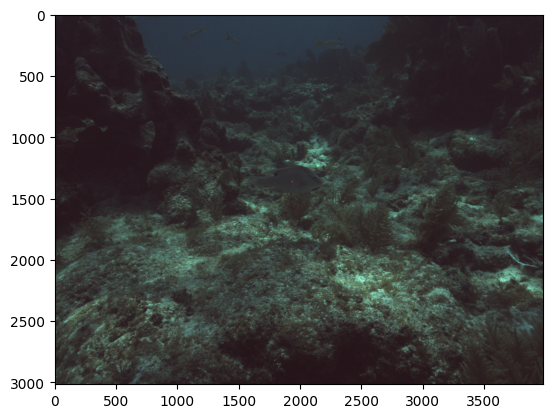

In [25]:
imshow(img_dark)

We can consider the brightest points in the image as regions of interest (ROI).  For each, we can use an ML model to check to see if they are the laser.

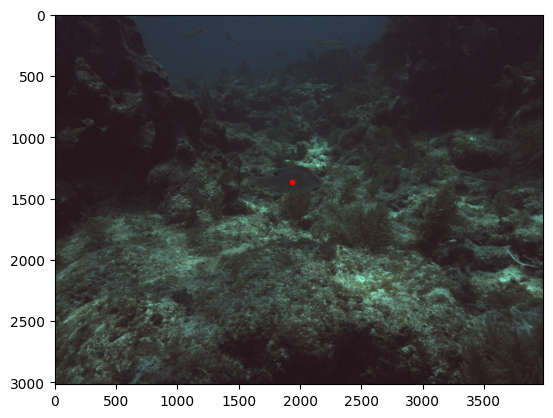

In [26]:
laser_detector = NNLaserDetector(lens_calibration, laser_calibration, device)
laser_coords = laser_detector.find_laser(img_dark8)
laser_coords_int = np.round(laser_coords).astype(int)

imshow(img_dark8)
plt.plot(laser_coords[0], laser_coords[1], 'r.')
plt.show()

In [27]:
depth_map = LaserDepthMap(laser_coords, lens_calibration, laser_calibration)
print(f"Distance to the fish is {depth_map.depth_map[0, 0]: 0.2f}m.")

Distance to the fish is  1.37m.


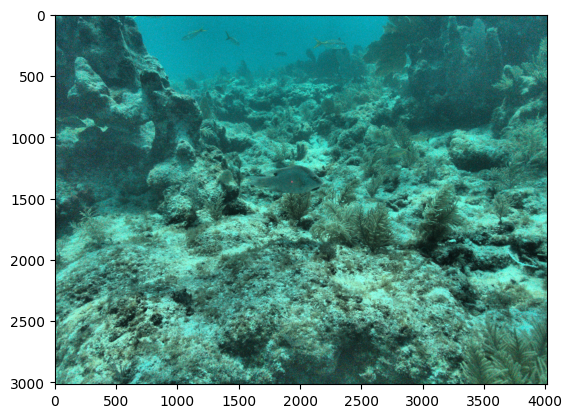

In [28]:
imshow(img8)

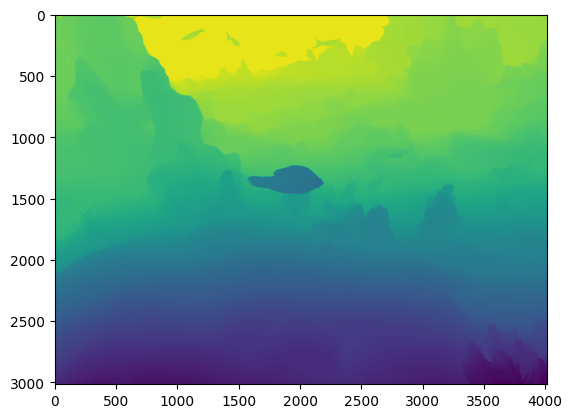

In [29]:
ml_depth_map = DepthAnythingDepthMap(img8, device)
scale = depth_map.depth_map[0, 0] / ml_depth_map.depth_map[int(laser_coords[1]), int(laser_coords[0])]
ml_depth_map.rescale(scale)

plt.imshow(ml_depth_map.depth_map)

Estimating backscatter...
Finding backscatter coefficients...
Constructing neighborhood map...
Refining neighborhood map...
Estimating illumination...
Estimating wideband attenuation...
Found best loss 0.31931407182247973
Found best loss 0.4166266335274145
Found best loss 0.5567094330154893
Reconstructing image...


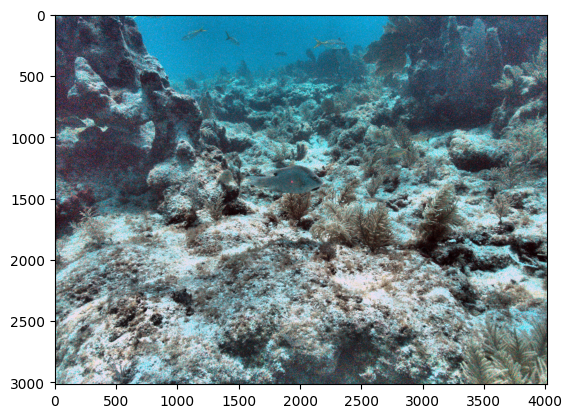

In [30]:
color_correction = ColorCorrection()
img_corrected = color_correction.correct_color(img8, ml_depth_map)

imshow(img_corrected)

We use Fishial to find the mask for the fish.

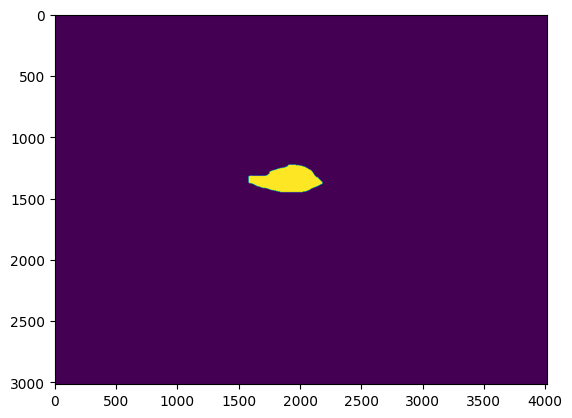

In [31]:
fish_segmentation_inference = FishSegmentationFishialPyTorch(device)
# fish_segmentation_inference = FishSegmentationFishialOnnx()
# fish_segmentation_inference = FishSegmentation()
segmentations = fish_segmentation_inference.inference(img_corrected)

plt.imshow(segmentations)
plt.show()

Given the location of the laser previously calculated, we can choose the fish that has the laser on it.

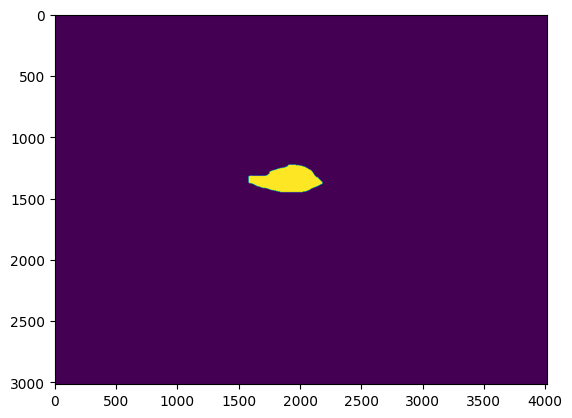

In [32]:
mask = np.zeros_like(segmentations, dtype=bool)
mask[segmentations == segmentations[laser_coords_int[1], laser_coords_int[0]]] = True

plt.imshow(mask)
plt.show()

We can then use the axis of most symmetry for the blob to detect the head and tail.

Tail in poly? False


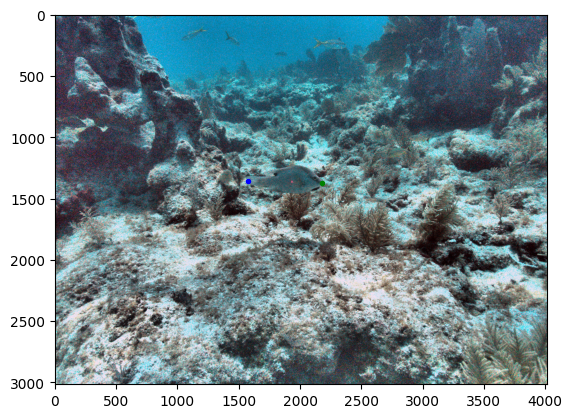

In [33]:
fish_head_tail_detector = FishPointsOfInterestDetector()
left_coord, right_coord = fish_head_tail_detector.find_points_of_interest(mask)

imshow(img_corrected)
plt.plot(left_coord[0], left_coord[1], 'g.')
plt.plot(right_coord[0], right_coord[1], 'b.')
plt.show()

We can use the laser location to find the distance to the fish.

We can finally use this distance and project the head/tail locations to this distance.  Using this, we can calculate the final length.

In [34]:
image_height, image_width, _ = img.shape

left_coord3d = depth_map.get_camera_space_point(left_coord, image_width, image_height, lens_calibration)
right_coord3d = depth_map.get_camera_space_point(right_coord, image_width, image_height, lens_calibration)

length = np.linalg.norm(left_coord3d - right_coord3d)
print(f"Fish Length is {length: 0.2f}m.")

Fish Length is  0.29m.
